Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134529 entries, 0 to 134528
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   AGE                     134529 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  134529 non-null  object
 2   SEX                     134529 non-null  object
 3   PATHOLOGY               134529 non-null  object
 4   EVIDENCES               134529 non-null  object
 5   INITIAL_EVIDENCE        134529 non-null  object
dtypes: int64(1), object(5)
memory usage: 6.2+ MB
None

Statistical Summary:

                  AGE                             DIFFERENTIAL_DIAGNOSIS  \
count   134529.000000                                             134529   
unique            NaN                                              45105   
top               NaN  [['Localized edema', 0.6962440370572797], ['Ch...   
freq              NaN                                               1

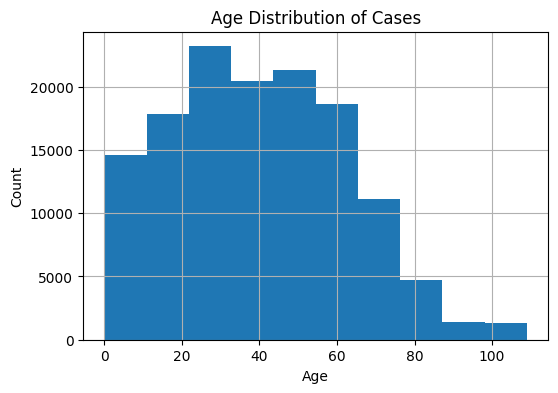

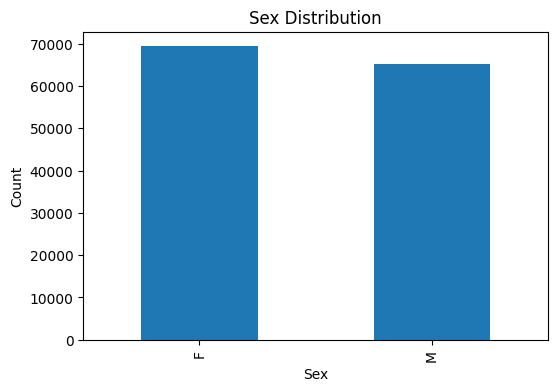

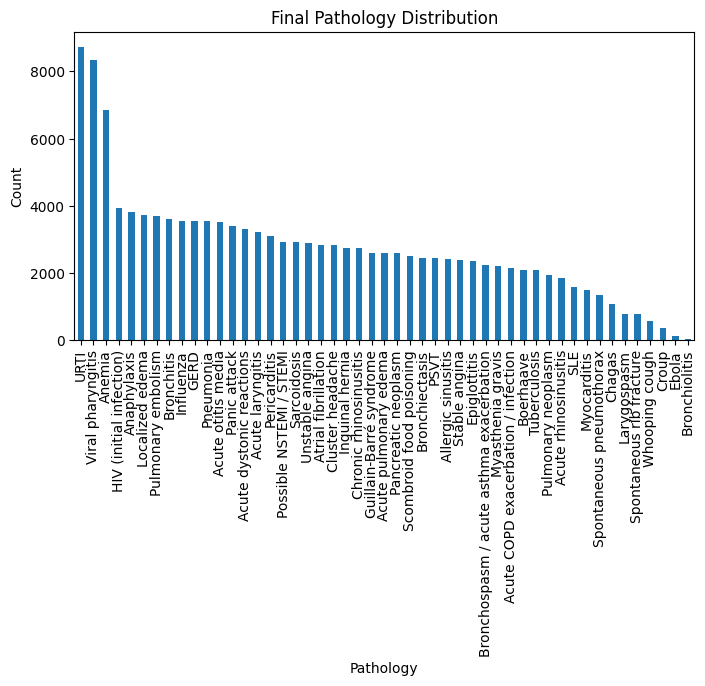

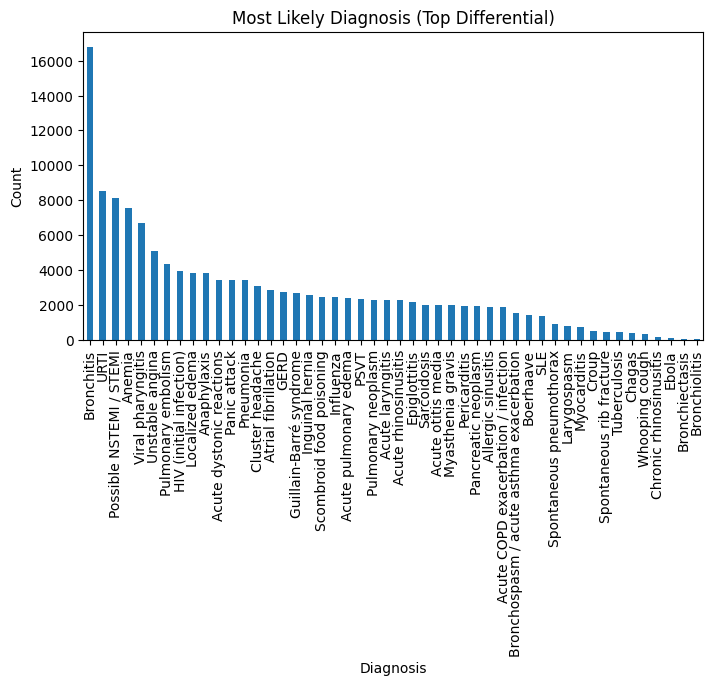

In [1]:
# DDX Dataset - Basic EDA & Visualization (For AI Chatbot Project)

# --- 1. Imports
import pandas as pd
import ast
import matplotlib.pyplot as plt

# --- 2. Load Dataset
# Replace 'ddx_sample.csv' with actual file path
df = pd.read_csv('test.csv')

# For preview purposes, manually define a small sample (remove when using actual file)



# --- 3. Basic EDA
print("Dataset Info:\n")
print(df.info())

print("\nStatistical Summary:\n")
print(df.describe(include='all'))

print("\nMissing Values:\n")
print(df.isnull().sum())

# --- 4. Clean DIFF DIAGNOSIS column

def parse_diff_diag(x):
    try:
        return ast.literal_eval(x)
    except:
        return []


df['DIFF_LIST'] = df['DIFFERENTIAL_DIAGNOSIS'].apply(parse_diff_diag)

# Extract top diagnosis name per row
df['TOP_DIAGNOSIS'] = df['DIFF_LIST'].apply(lambda x: x[0][0] if len(x) > 0 else None)

# --- 5. Visualizations

# Age distribution
plt.figure(figsize=(6,4))
df['AGE'].hist()
plt.title('Age Distribution of Cases')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Sex distribution
plt.figure(figsize=(6,4))
df['SEX'].value_counts().plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Pathology counts
plt.figure(figsize=(8,4))
df['PATHOLOGY'].value_counts().plot(kind='bar')
plt.title('Final Pathology Distribution')
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()

# Top differential diagnosis distribution
plt.figure(figsize=(8,4))
df['TOP_DIAGNOSIS'].value_counts().plot(kind='bar')
plt.title('Most Likely Diagnosis (Top Differential)')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

# --- 6. Conclusion section (for report)
# This section describes how EDA supports the chatbot project:
# - Understanding common pathologies helps shape model output space.
# - Age/sex distribution ensures prediction fairness.
# - Differential diagnosis lists help train ranking and probability reasoning.
# - Evidence patterns guide symptom-based question generation.
